# Future Prediction 🔮
The objective is to approximate the future, and how the US-Sensors are going to behave. An emergency stop could be triggered, if safe operating conditions are not met anymore.
As GP doesn´t allow time series data to be processed directly, the US-Sensors data gets lagged in the Data_lagging.py module.

### Gaussian Process
The model of choice is a GP, as confidence intervals could be useful in application.

The data is prepared in the Data_set_build.ipynb notebook and shall be saved in an db_fut_X.csv file which gets fed into the current notebook. 

In [1]:
#!pip install scikit-learn
#!pip install nbimporter

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from merging_data_to_uniform_layout import datacut

In [3]:
data = pd.read_csv('Data/data.csv')

X = np.loadtxt('db_fut_X.csv', delimiter=',')[:, 0:10]
Y = np.loadtxt('db_fut_X.csv', delimiter=',')[:, [10, 11]]

X_train, X_test, Y_train, Y_test = train_test_split(X,  Y, test_size=0.8, shuffle=True)

In [4]:
kernel = RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train, Y_train)


/opt/conda/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1))

In [5]:
### Saving of the trained model:
#joblib.dump(gp, 'GaussianProcessRegressor.sav')
#gp = joblib.load('GaussianProcessRegressor.sav')

In [6]:
# Make predictions on the test set
Y_pred, Y_std = gp.predict(X_test, return_std=True)  # Returns both prediction and uncertainty

# Calculate mean squared error
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"R²-Score of the test data: {r2:.2f}")
print(f"Mean Squared Error: {mse}")

R²-Score of the test data: 1.00
Mean Squared Error: 9.050763340022011e-13


# Display forecasted n steps: results and uncertainty

In [7]:
# Function to forecast next n_steps values
def forecast_future(model, last_step, n_steps, n_lags):
    forecasted_values = []
    forecasted_std = []
    last_X1 = last_step[0:n_lags]
    last_X2 = last_step[n_lags:]
    for _ in range(n_steps):
        # Predict the next value and standard deviation
        last_lag = np.append(last_X1, last_X2)
        pred, std = model.predict(last_lag.reshape(1, -1), return_std=True)
        forecasted_values.append(pred.flatten())
        forecasted_std.append(std.flatten())

        # Update the sequence with the new predicted value
        last_X1 = np.append(last_lag[1:n_lags], pred[:, 0])
        last_X2 = np.append(last_lag[n_lags+1:], pred[:, 1])
    # Transform the forecasted values back to the original scale

    forecasted_values = np.vstack(forecasted_values)
    forecast = scalerh.inverse_transform(forecasted_values[:, 0].reshape(-1, 1))
    forecast_sc = np.append(forecast, scalerv.inverse_transform(np.array(forecasted_values)[:, 1].reshape(-1, 1)), axis=1)
    return forecast_sc, np.array(forecasted_std)

In [10]:
n_steps = 100
n_lags = 5
#gp = joblib.load('GaussianProcessRegressor.sav')

valid = datacut('Data/Original/' + '001_l_000N_fa_r_f.csv')
from Data_lagging import lagging
X_val, Y_val, scalerh, scalerv= lagging.create_lag_Gauss(valid, n_lags)

Y_pred, predicted_std = forecast_future(gp, X_val[0], n_steps, n_lags)
print("Forecasted future values:", len(Y_pred))
print("Uncertainty (standard deviation) of forecasts:", len(predicted_std))

Y_real = valid.loc[n_lags+1: (n_lags+n_steps), ['US horizontal', 'US vertical']]
t_real = valid.loc[n_lags+1: (n_lags+n_steps), ['Timestamp']]
t_rel = t_real.sub(t_real.iloc[0, 0])
# Xav = valid['Timestamp'].diff().mean() for calculating time vector

Column  0  is ok
Column  2  is ok
Column  4  is ok
Column  6  is ok
Column  8  is ok
Column  10  is ok
Initial length:  223 
 Cut ticks at beginning:  3 
 Cut away ticks at ending:  6 
 Resumes in  214 Ticks 
 The average Revolution duration[ms] :  0.8071740467452144
Lag-Lines created:  21546
Forecasted future values: 100
Uncertainty (standard deviation) of forecasts: 100


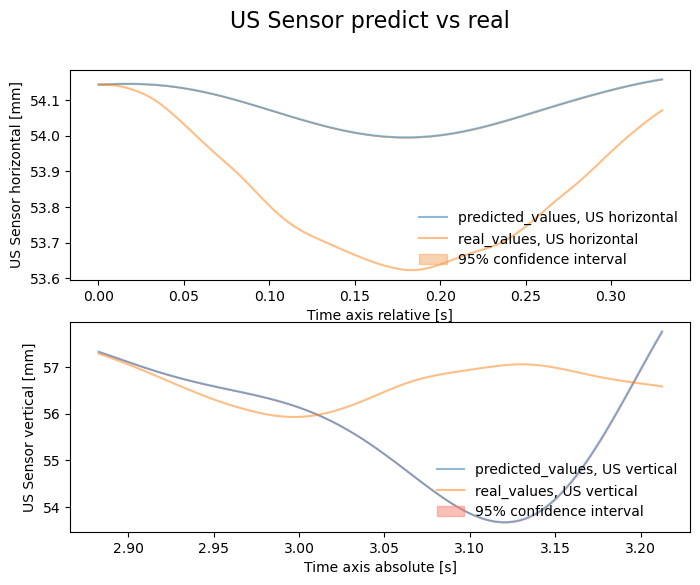

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(8, 6))
plt.suptitle('US Sensor predict vs real', fontsize=16)
ax1.plot(t_rel, Y_pred[:, 0], label="predicted_values, US horizontal", alpha=0.5)
ax1.plot(t_rel, Y_real.iloc[:, 0], label="real_values, US horizontal", alpha=0.5)
ax1.fill_between(
    t_rel.values.flatten(),
    (Y_pred[:, 0] - 1.96 * predicted_std[:, 0]),
    (Y_pred[:, 0] + 1.96 * predicted_std[:, 0]), alpha=0.5,
    label=r"95% confidence interval", color='sandybrown')
ax1.legend(frameon=False, loc='lower right')
ax1.set_ylabel('US Sensor horizontal [mm]')
ax1.set_xlabel('Time axis relative [s]')
ax2.plot(t_real, Y_pred[:, 1], label="predicted_values, US vertical", alpha=0.5)
ax2.plot(t_real, Y_real.iloc[:, 1], label="real_values, US vertical", alpha=0.5)
ax2.fill_between(
    t_real.values.flatten(),
    (Y_pred[:, 1] - 1.96 * predicted_std[:, 1]),
    (Y_pred[:, 1] + 1.96 * predicted_std[:, 1]), alpha=0.5,
    label=r"95% confidence interval", color='salmon')
ax2.legend(frameon=False, loc='lower right')
ax2.set_ylabel('US Sensor vertical [mm]')
ax2.set_xlabel('Time axis absolute [s]')
plt.savefig("Pics/Future_Prediction.svg", format="svg")
plt.show()